In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd

In [5]:
df = pd.read_csv('/Users/leo/Documents/Summer School/xica_data_new.csv')

In [6]:
df.head(-1)

,RO,AC,AM,RR,PA,AP,TO,MA,PI,CE,...,GO,DF,IG,Total,year,month,Date,DaysInMonth,DailyCases,Days
0,167,64.0,109,108,2370,67.0,642,446,58,2535,...,102,51,1.0,13600,2017,1,2017-01-01,31,438.709677,0
1,177,36.0,124,202,2305,58.0,825,1047,82,4652,...,99,28,1.0,17853,2017,2,2017-02-01,28,637.607143,31
2,156,40.0,122,348,1789,95.0,1143,1973,284,18529,...,111,52,1.0,37924,2017,3,2017-03-01,31,1223.354839,59
3,56,23.0,76,542,1174,59.0,1047,1832,738,43700,...,89,41,1.0,57408,2017,4,2017-04-01,30,1913.600000,90
4,60,46.0,45,1030,908,74.0,1299,1246,1818,44576,...,108,65,1.0,57054,2017,5,2017-05-01,31,1840.451613,120
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73,63,17.0,36,88,152,4.0,2994,430,519,1054,...,392,132,1.0,35548,2023,2,2023-02-01,28,1269.571429,2222
74,145,78.0,88,49,312,7.0,2494,750,1036,1870,...,408,155,1.0,45450,2023,3,2023-03-01,31,1466.129032,2250
75,176,57.0,67,28,268,11.0,1900,705,1081,1548,...,629,138,1.0,39875,2023,4,2023-04-01,30,1329.166667,2281
76,132,28.0,33,30,246,15.0,1115,720,800,1410,...,629,153,1.0,29764,2023,5,2023-05-01,31,960.129032,2311


In [7]:
def temp_fun_br(t):
    return 1.42432*2*np.sin(2*np.pi*t/365+2.2)+24.182

In [8]:
def temp_fun_mia(t):
    return 2.91*1.25*np.sin(2*np.pi*t/365 + 3.7)+25.91

In [9]:
def b_m(t, temp_fun):
    return 0.0943 + 0.0043*temp_fun(t)

In [10]:
def B(t, temp_fun):
    return 1/2

In [11]:
def C(t, temp_fun):
    return 1

In [12]:
def beta_mh(t, temp_fun):
    b = 0.13
    return b

In [13]:
def beta_hm(t,temp_fun):
    c = 0.3
    return c

In [14]:
def mu_m(t, temp_fun):
    return 0.8692 - 0.1590*temp_fun(t) + 0.01116*(temp_fun(t)**2) -0.0003408*(temp_fun(t)**3)+3.809*(10**(-6))*(temp_fun(t)**4)

In [15]:
def eta_b(t, temp_fun):
    return 0.0591*(-5.4 + 1.8*temp_fun(t) - 0.2124*temp_fun(t)**2 + (1.015/100)*(temp_fun(t)**3) - (1.515/10000)*temp_fun(t)**4)

In [16]:
def mu_L(t, temp_fun):
    return 2.130 - 0.3797*temp_fun(t) + (0.02457*temp_fun(t)**2) - (0.0006778*temp_fun(t)**3) + 0.000006794*temp_fun(t)**4

In [17]:
def eta_L(t, temp_fun):
    return 0.00070067*(temp_fun(t)+273.15)*np.exp(13093*(1/298 - 1/(temp_fun(t)+273.15)))/(1+np.exp(28715*(1/304.6 - 1/(temp_fun(t)+273.15))))

In [18]:
def model(t, z, KB, KM):
    ShB, EhB, IncB, IhB, AhB, RhB, SmB, EmB, ImB, LIB, LSB, ShM, EhM, IncM, IhM, AhM, RhM, SmM, EmM, ImM, LIM, LSM = z
    
    #----- Functions
    
    # b_m(t) - Mosquito bith rate
    # B(t) - Average daily biting (per day)
    # beta_mh(t) - Transmission probability from Im
    # mu_m(t) - Mosquito death rate
    # beta_hm(t) - Transmission probability from I h
    
    #------------------
    
    #Parameters
    
    b_h = 53/(2000*365) #humans bithrate
    mu_h = 0 #1/(78*356) #humans deathrate
    v_h = 1/4 #1/Intrinsic incubation period (in days) 3-4 days
    eta_m = 1/4 # 1/Extrinsic incubation period 2-6 days
    eta_h = 1/4 # 1/Mean viremic period (in days) 3-4 days
    
    p = 1/4 #Vertical trasnmission probablility
    
    mBM = -np.log(1-(800000/365)/203062512) #travel rate
    mMB = -np.log(1-(800000/365)/6140000) #travel rate
    
    #---------------------------
    
    #System - BRaziliuuul
    
    #Param
    
    NhB = ShB + IhB + EhB + RhB #current population of mosquitos
    #Nm0B = 6 * NhB #initial population of mosquitos
    NmB = SmB + ImB + EmB #current population of mosquitos
    #KB = NhB #Carrying capacity
    a=.4 #proportion of asymptomatic people
    #----------- Humans    
    DShB = mu_h*NhB - b_m(t, temp_fun_br)*beta_mh(t, temp_fun_br)*ImB*ShB/NhB - mu_h*ShB + mMB*ShM - mBM*ShB 
    DEhB = b_m(t, temp_fun_br)*beta_mh(t, temp_fun_br)*ImB*ShB/NhB - v_h*EhB - mu_h*EhB + mMB*EhM - mBM*EhB
    DIncB = (1-a)*v_h*EhB
    DIhB = DIncB - eta_h*IhB - mu_h*IhB 
    DAhB = a*v_h*EhB - eta_h*AhB - mu_h*AhB + mMB*AhM - mBM*AhB
    DRhB = eta_h*IhB - mu_h*RhB + mMB*RhM - mBM*RhB 
    
    #----------- Mosquitos
    DSmB = eta_L(t, temp_fun_br)*LSB - b_m(t, temp_fun_br)*beta_hm(t, temp_fun_br)*IhB*SmB/NhB - mu_m(t, temp_fun_br)*SmB
    DEmB = b_m(t, temp_fun_br)*beta_hm(t, temp_fun_br)*IhB*SmB/NhB - eta_m*EmB - mu_m(t, temp_fun_br)*EmB
    DImB = eta_m*EmB - mu_m(t, temp_fun_br)*ImB + eta_L(t, temp_fun_br)*LIB
    
    #------------Larvas
    DLIB = eta_b(t, temp_fun_br)*(1-(LIB+LSB)/KB)*p*ImB - eta_L(t, temp_fun_br)*LIB - mu_L(t, temp_fun_br)*LIB
    DLSB = eta_b(t, temp_fun_br)*(1-(LSB+LIB)/KB)*(SmB+EmB+(1-p)*ImB) - eta_L(t, temp_fun_br)*LSB - mu_L(t, temp_fun_br)*LSB
    
    #------------------------------------------------------------------------------------------
    
    #System - Miami
    
    #Param
    
    NhM = ShM + IhM + EhM + RhM #current population of mosquitos
    Nm0M = 6 * NhM #initial population of mosquitos
    NmM = SmM + ImM + EmM #current population of mosquitos
    #KM = NhM #Carrying capacity
    
    #----------- Humans    
    DShM = mu_h*NhM - b_m(t, temp_fun_mia)*beta_mh(t, temp_fun_mia)*ImM*ShM/NhM - mu_h*ShM + mBM*ShB - mMB*ShM
    DEhM = b_m(t, temp_fun_mia)*beta_mh(t, temp_fun_mia)*ImM*ShM/NhM - v_h*EhM - mu_h*EhM + mBM*EhB - mMB*EhM
    DIncM = (1-a)*v_h*EhM
    DIhM = (1-a)*v_h*EhM - eta_h*IhM - mu_h*IhM
    DAhM = a*v_h*EhM-eta_h*AhM-mu_h*AhM +(mBM*AhB-mMB*AhM)
    DRhM = eta_h*IhM - mu_h*RhM + mBM*RhB - mMB*RhM 
    
    #----------- Mosquitos
    DSmM = eta_L(t, temp_fun_mia)*LSM - b_m(t, temp_fun_mia)*beta_hm(t, temp_fun_mia)*(IhM+AhM)*SmM/NhM - mu_m(t, temp_fun_mia)*SmM
    DEmM = b_m(t, temp_fun_mia)*beta_hm(t, temp_fun_mia)*(IhM+AhM)*SmM/NhM - eta_m*EmM - mu_m(t, temp_fun_mia)*EmM
    DImM = eta_m*EmM - mu_m(t, temp_fun_mia)*ImM + eta_L(t, temp_fun_mia)*LIM
    
    #------------Larvas
    DLIM = eta_b(t, temp_fun_mia)*(1-(LIM+LSM)/KM)*p*ImM - eta_L(t, temp_fun_mia)*LIM - mu_L(t, temp_fun_mia)*LIM
    DLSM = eta_b(t, temp_fun_mia)*(1-(LSM+LIM)/KM)*(SmM+EmM+(1-p)*ImM) - eta_L(t, temp_fun_mia)*LSM - mu_L(t, temp_fun_mia)*LSM
    
    return [DShB, DEhB, DIncB, DIhB, DAhB, DRhB, DSmB, DEmB, DImB, DLIB, DLSB, DShM, DEhM, DIncM, DIhM, DAhM, DRhM, DSmM, DEmM, DImM, DLIM, DLSM]

In [19]:
def num_sol(t, KB, KM, EmB_0, ImB_0): #Numerical solution
    
    #KM = 6140000.00
    
    #------
    
    Nh0B = 203062512
    Initial_larvaB = KB*(1-mu_m(0, temp_fun_br)*(eta_L(0, temp_fun_br)+mu_L(0, temp_fun_br))/(eta_L(0, temp_fun_br)*eta_b(0, temp_fun_br)))
   
    Nh0M = 6140000 
    Initial_larvaM = KM*(1-mu_m(0, temp_fun_mia)*(eta_L(0, temp_fun_mia)+mu_L(0, temp_fun_mia))/(eta_L(0, temp_fun_mia)*eta_b(0, temp_fun_mia)))

    #-----


    #segundo pesquisa citada na cell abaixo ha em media 717 casos de CHIKV por dia no BR-de jan ate mar de 2023
    #consideramos roughly que ha o mesmo numero de mosquitos infectados no dia inicial considerado
    #levando isso em conta, por https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2966317/#:~:text=Egg%20collections%20can%20be%20made,lay%20%E2%88%BC100%2D150%20eggs, consideramos que cada mosquito gravida lay ~100eggs during 3 days
    #About three days after feeding on blood, the female lays her eggs inside a container just: https://www.moorparkca.gov/DocumentCenter/View/8360/Aedesaegypti-Fact-Sheet#:~:text=The%20entire%20life%20cycle%20(i.e.,day%2C%20both%20indoors%20and%20outdoors.
    #sendo assim, consideramos q a condicao inicial de LIB eh 120/3 *717,dado q cada femea gera 150 ovos
    #ShB, EhB, IhB, AhB, RhB, SmB, EmB, ImB, LIB, LSB, ShM, EhM, IhM, AhM, RhM, SmM, EmM, ImM, LIM, LSM
    
    #https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5875253/
    #Initial value for recovered individuals

    
    init_cond = [Nh0B, 16*439*5/3, 439, 4*439*5/3, 439*2/3, 20661+271824, Initial_larvaB * eta_L(0, temp_fun_br)/mu_m(0, temp_fun_br) - ImB_0 - EmB_0, EmB_0, ImB_0, (1/4)*125*ImB_0/3, Initial_larvaB - (1/4)*125*ImB_0/3, Nh0M, 0, 0, 0, 0, 0, Initial_larvaM * eta_L(0, temp_fun_mia)/mu_m(0, temp_fun_mia), 0, 0, 0, Initial_larvaM]
    
    #----------------
    
    F = lambda t, z: model(t, z, KB, KM)
    
    solution = solve_ivp(F, [0,3000], init_cond, dense_output = True,  rtol = 1e-3, atol = 1e-3)

    return solution.sol(t)

In [20]:
def fun(x, t, y = 0): # function we want to fit where x[0], x[1] and x[2] we are estimating
    ShB_0, EhB_0, IncB_0, IhB_0, AhB_0, RhB_0, SmB_0, EmB_0, ImB_0, LIB_0, LSB_0, ShM_0, EhM_0, IncM_0, IhM_0, AhM_0, RhM_0, SmM_0, EmM_0, ImM_0, LIM_0, LSM_0 = num_sol(t-1, x[0], x[1], x[2], x[3])
    ShB_1, EhB_1, IncB_1, IhB_1, AhB_1, RhB_1, SmB_1, EmB_1, ImB_1, LIB_1, LSB_1, ShM_1, EhM_1, IncM_1, IhM_1, AhM_1, RhM_1, SmM_1, EmM_1, ImM_1, LIM_1, LSM_1 = num_sol(t, x[0], x[1], x[2], x[3])
    
    
    
    return (IncB_1 - IncB_0) - y

In [21]:
KB = 234271331.00
KM=6547000.00
EmB_0=100
ImB_0=5950
t_temp = np.arange(0, 2343)

    
ShB, EhB, IncB, IhB, AhB, RhB, SmB, EmB, ImB, LIB, LSB, ShM, EhM, IncM, IhM, AhM, RhM, SmM, EmM, ImM, LIM, LSM = num_sol(t_temp, KB, KM, EmB_0, ImB_0)

dayly_Inc_B = [IncB[i] - IncB[i-1] for i in np.arange(1, 2343)]

In [26]:
def num_sol_plt(KB = 234271331.00, KM=6547000.00, EmB_0=100, ImB_0=5950):
    
    KM = 6140000/2
    
    t = df['Days'].to_numpy()
    y = df['DailyCases'].to_numpy()
    
    t_temp = np.arange(0, 2343)
    
    t_plot = np.arange(1, 2343)
    
    ShB, EhB, IncB, IhB, AhB, RhB, SmB, EmB, ImB, LIB, LSB, ShM, EhM, IncM, IhM, AhM, RhM, SmM, EmM, ImM, LIM, LSM = num_sol(t_temp, KB, KM, EmB_0, ImB_0)

    dayly_Inc_B = [IncB[i] - IncB[i-1] for i in np.arange(1, 2343)]
    
    plt.plot(t_plot, dayly_Inc_B, '-', linewidth=2, label='true')

    plt.plot(t, y, 'o', linewidth=2, label='true')

    plt.xlabel("t")
    plt.ylabel("x")
    plt.legend()
    plt.show()

In [30]:
import ipywidgets

ipywidgets.interact(num_sol_plt, KB = (200700862, 2*200700862, 100000) , KM = (6140000/2, 10*6140000 , 1000), EmB_0 = (100, 10000, 50), ImB_0 = (100, 10000, 50) )

interactive(children=(IntSlider(value=234271331, description='KB', max=401401724, min=200700862, step=100000),…

<function __main__.num_sol_plt(KB=234271331.0, KM=6547000.0, EmB_0=100, ImB_0=5950)>

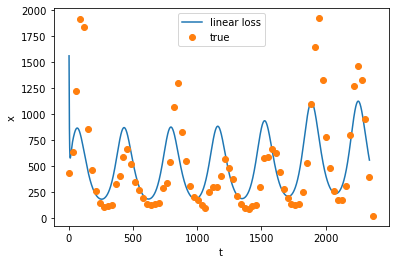

[3.29216754e+08 5.46804631e+06 4.79644031e+02 3.09567802e+03]


In [31]:
from scipy.optimize import least_squares
from sklearn.linear_model import LinearRegression

t = df['Days'].to_numpy()
y = df['DailyCases'].to_numpy()

x0 = [317800862, 6140000, 1.00000209e+02, 10000]# initial point for the constants x[0] = f , x[1] = c


#-----
res_lsq = least_squares(fun, x0, args=(t, y), bounds=([200700862/2, 6140000/2, 100, 100], [9*200700862, 2*6140000, 10000, 10000]))

KB, KM, EmB_0, ImB_0 = res_lsq.x

t_temp = np.arange(0, 2343)
    
t_plot = np.arange(1, 2343)

ShB, EhB, IncB, IhB, AhB, RhB, SmB, EmB, ImB, LIB, LSB, ShM, EhM, IncM, IhM, AhM, RhM, SmM, EmM, ImM, LIM, LSM = num_sol(t_temp, KB, KM, EmB_0, ImB_0)

dayly_Inc_B = [IncB[i] - IncB[i-1] for i in t_plot]

plt.plot(t_plot, dayly_Inc_B, label='linear loss')

plt.plot(t, y, 'o', linewidth=2, label='true')

plt.xlabel("t")
plt.ylabel("x")
plt.legend()
plt.show()

print(res_lsq.x)

In [21]:
def num_sol_plt_2():

    
    t = np.arange(0, 750)
    #KB, KM, EmB_0, ImB_0 = [234271331.00 , 6547000.00, 100, 2900]
    
    #KB, KM, EmB_0, ImB_0 = [212428631.00, 6140000, 1950, 3400]
    
    #KB, KM, EmB_0, ImB_0 = [2.92353037e+08, 5.58782797e+06, 1.00000209e+02, 1.97516413e+03]
    
    #KB, KM, EmB_0, ImB_0 = [2.92352958e+08, 1.22493000e+07, 1.07570769e+01, 1.98381846e+03]
    
    KB, KM, EmB_0, ImB_0 =  [3.03769585e+08, 6140000/2, 1.00000602e+02, 8.39703839e+03]

    
    
    ShB, EhB, IncB, IhB, AhB, RhB, SmB, EmB, ImB, LIB, LSB, ShM, EhM, IncM, IhM, AhM, RhM, SmM, EmM, ImM, LIM, LSM = num_sol(t, KB, KM, EmB_0, ImB_0)
    
    t_plot = np.arange(1, 500)

    dayly_Inc_B = [IncB[i] - IncB[i-1] for i in t_plot]

    #Brasil-----------
    print('Brazil 2023')
    
   # plt.plot(t, ShB, label = 'Sh')
   # plt.plot(t, EhB, label ='Eh')
   # plt.plot(t, IhB, label ='Ih')
   # plt.plot(t, RhB, label ='Rh')
   # plt.xlabel("t (days)")
   # plt.ylabel("Number of Individuals Brazil")
   # plt.legend(['Sh', 'Eh', 'Ih', 'Rh'], shadow=True)
   # plt.show()
    
    fig,ax=plt.subplots()
    
    ax.scatter(df.index, df['cases'], label='Data of newly Infected Individuals', color='red', marker='o')
    
    ax.plot(t_plot, dayly_Inc_B, label ='dayly_Inc_B')
    ax.set_xlabel("t (days)")
    ax.set_ylabel("Number of newly Infected Individuals in Brazil per day")
    ax.legend()
    plt.show()

    ax.plot(t, IhB, label ='IhB')
    ax.set_xlabel("t (days)")
    ax.set_ylabel("Number of Infected Individuals in Brazil per day")
    ax.legend()
    plt.show()
    
    plt.plot(t, RhB, label ='Rh')
    plt.xlabel("t (days)")
    plt.ylabel("Number of Recovered Individuals Brazil")
    plt.legend(['Rh'], shadow=True)
    plt.show()
    
    #plt.plot(t, EmB, label = 'Em')
    #plt.plot(t, ImB, label = 'Im')
    #plt.xlabel("t (days)")
    #plt.ylabel("Number of Mosquitos Brazil")
    #plt.legend(['Em', 'Im'], shadow=True)
    #plt.show()
    
    plt.plot(t, SmB, label = 'Sm')
    #plt.xlabel("t (days)")
    plt.ylabel("Number of Susceptible Mosquitos Brazil")
    #plt.legend(['Sm'], shadow=True)
    plt.show()
    
    #plt.plot(t, LSB, label = 'LS')
    #plt.plot(t, LIB, label = 'LI')
    #plt.xlabel("t (days)")
    #plt.ylabel("Number of Larva Brazil")
    #plt.legend(['LS', 'LI'], shadow=True)
    #plt.show()
    
    #Miami-----------
    print('Miami 2023')
    
   # plt.plot(t, ShM, label = 'Sh')
   # plt.plot(t, EhM, label ='Eh')
    #plt.plot(t, IhM, label ='Ih')
    #plt.plot(t, RhM, label ='Rh')
    #plt.xlabel("t (days)")
    #plt.ylabel("Number of Individuals Miami")
    #plt.legend(['Sh', 'Eh', 'Ih', 'Rh'], shadow=True)
    #plt.show()
    

    plt.plot(t, IhM, label ='Ih')
    plt.xlabel("t (days)")
    plt.ylabel("Number of Infected Individuals Miami")
    plt.legend(['Ih'], shadow=True)
    plt.show()
    
   
    #plt.plot(t, RhM, label ='Rh')
    #plt.xlabel("t (days)")
    #plt.ylabel("Number of Recovered Individuals Miami")
    #plt.legend(['Rh'], shadow=True)
    #plt.show()

    
   # plt.plot(t, EmM, label = 'Em')
    #plt.plot(t, ImM, label = 'Im')
    #plt.xlabel("t (days)")
    #plt.ylabel("Number of Individuals")
    #plt.legend(['Em', 'Im'], shadow=True)
    #plt.show()
    
    #plt.plot(t, SmM, label = 'Sm')
    #plt.xlabel("t (days)")
    #plt.ylabel("Number of Individuals")
    #plt.legend(['Sm'], shadow=True)
    #plt.show()
    
    #plt.plot(t, LSM, label = 'LS')
    #plt.plot(t, LIM, label = 'LI')
    #plt.xlabel("t (days)")
    #plt.ylabel("Number of Individuals")
    #plt.legend(['LS', 'LI'], shadow=True)
    #plt.show()
    
   # plt.plot(t, IhM/IhB)
   # plt.xlabel("t (days)")
   # plt.ylabel("Ratio of Individuals")
   # plt.show()

In [ ]:
Nh0B = 203062512
K0B = Nh0B
Initial_larvaB = K0B*(1-mu_m(0, temp_fun_br)*(eta_L(0, temp_fun_br)+mu_L(0, temp_fun_br))/(eta_L(0, temp_fun_br)*eta_b(0, temp_fun_br)))
#------
Nh0M = 6140000 
K0M = Nh0M
Initial_larvaM = K0M*(1-mu_m(0, temp_fun_mia)*(eta_L(0, temp_fun_mia)+mu_L(0, temp_fun_mia))/(eta_L(0, temp_fun_mia)*eta_b(0, temp_fun_mia)))

#segundo pesquisa citada na cell abaixo ha em media 717 casos de CHIKV por dia no BR-de jan ate mar de 2023
#consideramos roughly que ha o mesmo numero de mosquitos infectados no dia inicial considerado
#levando isso em conta, por https://www.ncbi.nlm.nih.gov/pmc/articles/PMC2966317/#:~:text=Egg%20collections%20can%20be%20made,lay%20%E2%88%BC100%2D150%20eggs, consideramos que cada mosquito gravida lay ~100eggs during 3 days
#About three days after feeding on blood, the female lays her eggs inside a container just: https://www.moorparkca.gov/DocumentCenter/View/8360/Aedesaegypti-Fact-Sheet#:~:text=The%20entire%20life%20cycle%20(i.e.,day%2C%20both%20indoors%20and%20outdoors.
#sendo assim, consideramos q a condicao inicial de LIB eh 120/3 *717,dado q cada femea gera 150 ovos
#ShB, EhB, IhB,AhB, RhB, SmB, EmB, ImB, LIB, LSB, ShM, EhM, IhM, AhM, RhM, SmM, EmM, ImM, LIM, LSM
#init_cond = [200700862, 717, 717, 717*2/3, 2174016.915, Initial_larvaB * eta_L(0, temp_fun_br)/mu_m(0, temp_fun_br), 0, 717, 125/3*717, Initial_larvaB, Nh0M, 0, 0,0, 0, Initial_larvaM * eta_L(0, temp_fun_mia)/mu_m(0, temp_fun_mia), 0, 0, 0, Initial_larvaM]

Brazil 2023


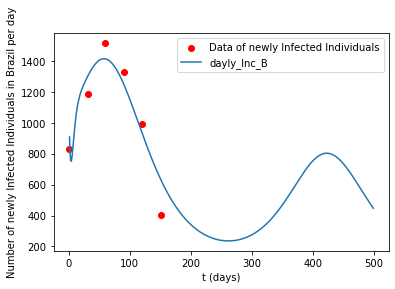

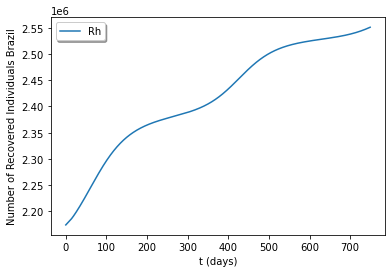

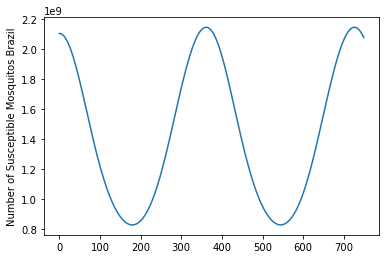

Miami 2023


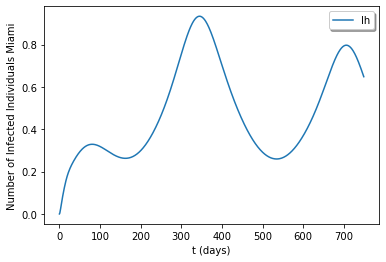

In [22]:
num_sol_plt_2()
#A temperatura mais favorável para o desenvolvimento da larva é entre 25 a 30ºC, e no Brasil, a temperatura media em novembro, dezembro eh abaixo disso, por isso ha uma decaida nos ultimos 60 dias do ano
#Source: https://prefeitura.poa.br/sms/onde-esta-o-aedes/o-aedes-aegypti#:~:text=A%20temperatura%20mais%20favor%C3%A1vel%20para,abaixo%20de%205%C2%BAC%20ele%20morre.
